# Setup & Imports

This cell sets up the Python environment and imports all necessary libraries and modules.

- Adds the parent directory to Python path to enable imports from `algorithms/` and `problems/`
- Imports essential libraries: numpy, matplotlib, time, csv, tracemalloc
- Configures matplotlib for inline display in Jupyter
- Imports all optimization algorithms (PSO, ABC, FA, CS, GA, HC, ACO, SA) and Knapsack problem functions


In [1]:
import sys
import os

# Add parent directory (project root) to Python path
# This allows notebook in /notebooks to import from /algorithms and /problems
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Import essential libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import csv
import tracemalloc

# Configure matplotlib for inline display in notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

# Import optimization algorithms and problem functions
from problems.knapsack import generate_knapsack_data, knapsack_fitness
from algorithms import aco, ga, sa, pso, abc, fa, cs, hc

print("✓ Imports successful!")
print(f"✓ Working directory: {os.getcwd()}")
print(f"✓ Module path added: {module_path}")


✓ Imports successful!
✓ Working directory: /mnt/d/02_University_HCMUS/Year_3/Sem_5/04_Intro2AI/algorithm/notebooks
✓ Module path added: /mnt/d/02_University_HCMUS/Year_3/Sem_5/04_Intro2AI/algorithm


# Configuration

Define all experiment parameters including:
- Number of runs for statistical averaging
- Problem sizes (number of items) to test
- Population size and maximum iterations
- Algorithm-specific parameters for each optimization method (including ACO and SA)


In [2]:
# Common parameters
N_RUNS = 10  # Number of runs for averaging
N_ITEMS_LIST = [20, 50]  # Test with different number of items
POP_SIZE = 50  # Population size
MAX_ITER = 50  # Maximum number of iterations

# Algorithm-specific parameters
ALGO_PARAMS = {
    'pso': {'w': 0.8, 'c1': 2.0, 'c2': 2.0},
    'abc': {'limit': 10},
    'fa': {'alpha': 0.5, 'beta0': 1.0, 'gamma': 0.95},
    'cs': {'pa': 0.25, 'beta': 1.5},
    'ga': {'crossover_rate': 0.8, 'mutation_rate': 0.05},
    'hc': {'step_size': 0.1},
    'aco': {'alpha': 1.0, 'beta': 2.0, 'rho': 0.5},
    'sa': {'initial_temp': 100.0, 'cooling_rate': 0.95, 'min_temp': 0.01}
}

ALGOS = {
    'PSO': pso.pso_discrete,
    'ABC': abc.abc_discrete,
    'FA': fa.firefly_discrete,
    'CS': cs.cuckoo_search_discrete,
    'GA': ga.genetic_discrete,
    'HC': hc.hill_climbing_discrete,
    'ACO': aco.aco_discrete,
    'SA': sa.simulated_annealing_discrete
}

print("=" * 60)
print("CONFIGURATION")
print("=" * 60)
print(f"N_RUNS = {N_RUNS}")
print(f"N_ITEMS_LIST = {N_ITEMS_LIST}")
print(f"POP_SIZE = {POP_SIZE}")
print(f"MAX_ITER = {MAX_ITER}")
print(f"Algorithms: {list(ALGOS.keys())}")
print("=" * 60)


CONFIGURATION
N_RUNS = 10
N_ITEMS_LIST = [20, 50]
POP_SIZE = 50
MAX_ITER = 50
Algorithms: ['PSO', 'ABC', 'FA', 'CS', 'GA', 'HC', 'ACO', 'SA']


# Run Experiments

Execute all optimization algorithms on the Knapsack problem for each problem size.

This cell:
- Generates knapsack problem instances with specified number of items
- Runs each algorithm N_RUNS times for statistical reliability
- Tracks convergence history, fitness values, execution time, and memory usage
- Computes summary statistics (mean, std, min, max) for each algorithm
- Stores data in memory for visualization and saving


In [3]:
# Experiment script
results_summary = []  # Store summary results
convergence_data = {}  # Store convergence history
raw_fitness_data = {}  # Store raw data for box plots

print("=" * 60)
print("KNAPSACK PROBLEM OPTIMIZATION EXPERIMENTS")
print("=" * 60)
print(f"Settings: N_RUNS={N_RUNS}, POP_SIZE={POP_SIZE}, MAX_ITER={MAX_ITER}")
print("=" * 60)

for n_items in N_ITEMS_LIST:
    print(f"\n{'='*60}")
    print(f"Running experiments for N_ITEMS={n_items}")
    print(f"{'='*60}")

    # Generate knapsack problem instance
    weights, values, capacity, _ = generate_knapsack_data(n_items, seed=42)
    context = {
        'weights': weights,
        'values': values,
        'capacity': capacity
    }

    print(f"Problem: {n_items} items, capacity={capacity}")
    print(f"Total weight: {np.sum(weights)}, Total value: {np.sum(values)}")

    convergence_data[n_items] = {}
    raw_fitness_data[n_items] = {}

    for algo_name, algo_func in ALGOS.items():
        print(f"\n[{algo_name}] Starting {N_RUNS} runs...")
        run_histories = []
        run_fitnesses = []
        run_times = []
        run_memories = []

        for r in range(N_RUNS):
            # Start memory tracing
            tracemalloc.start()
            start_time = time.time()

            if algo_name == 'ACO':
                # ACO doesn't need n_dim
                sol, fit, hist = algo_func(knapsack_fitness, context, POP_SIZE, MAX_ITER,
                                           **ALGO_PARAMS[algo_name.lower()])
            elif algo_name == 'HC' or algo_name == 'SA':
                # HC and SA don't need pop_size parameter
                sol, fit, hist = algo_func(knapsack_fitness, context, n_items, MAX_ITER,
                                           **ALGO_PARAMS[algo_name.lower()])
            else:
                # All other algorithms (PSO, ABC, FA, CS, GA) use _discrete functions
                sol, fit, hist = algo_func(knapsack_fitness, context, n_items, POP_SIZE, MAX_ITER,
                                           **ALGO_PARAMS[algo_name.lower()])

            elapsed = time.time() - start_time
            # Get peak memory usage (in MB)
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            peak_mem_mb = peak / 1024 / 1024  # Convert bytes to MB

            run_times.append(elapsed)
            run_fitnesses.append(fit)
            run_histories.append(hist)
            run_memories.append(peak_mem_mb)

            if (r + 1) % 5 == 0:
                print(f"  Run {r+1}/{N_RUNS} completed. Best fitness: {fit:.2f}")

        # Calculate statistics
        avg_fit = np.mean(run_fitnesses)
        std_fit = np.std(run_fitnesses)
        min_fit = np.min(run_fitnesses)
        max_fit = np.max(run_fitnesses)
        avg_time = np.mean(run_times)
        avg_peak_mem = np.mean(run_memories)

        print(f"[{algo_name}] Completed!")
        print(f"  Avg Fitness: {avg_fit:.2f} ± {std_fit:.2f}")
        print(f"  Min Fitness: {min_fit:.2f}")
        print(f"  Max Fitness: {max_fit:.2f}")
        print(f"  Avg Time: {avg_time:.4f}s")
        print(f"  Avg Peak Memory: {avg_peak_mem:.4f} MB")

        results_summary.append(
            [algo_name, n_items, avg_fit, std_fit, min_fit, max_fit, avg_time, avg_peak_mem])

        # Store average convergence history
        # Pad histories to same length if needed
        max_len = max(len(h) for h in run_histories)
        padded_histories = []
        for h in run_histories:
            if len(h) < max_len:
                # Pad with last value
                padded = list(h) + [h[-1]] * (max_len - len(h))
            else:
                padded = h
            padded_histories.append(padded)

        avg_convergence = np.mean(np.array(padded_histories), axis=0)

        convergence_data[n_items][algo_name] = avg_convergence

        # Save raw fitness data for box plots
        raw_fitness_data[n_items][algo_name] = run_fitnesses

print(f"\n{'='*60}")
print("EXPERIMENTS COMPLETED!")
print(f"{'='*60}")


KNAPSACK PROBLEM OPTIMIZATION EXPERIMENTS
Settings: N_RUNS=10, POP_SIZE=50, MAX_ITER=50

Running experiments for N_ITEMS=20
Problem: 20 items, capacity=71
Total weight: 178, Total value: 1103

[PSO] Starting 10 runs...
  Run 5/10 completed. Best fitness: -720.00
  Run 10/10 completed. Best fitness: -651.00
[PSO] Completed!
  Avg Fitness: -652.60 ± 41.96
  Min Fitness: -720.00
  Max Fitness: -589.00
  Avg Time: 0.1090s
  Avg Peak Memory: 0.0349 MB

[ABC] Starting 10 runs...
  Run 5/10 completed. Best fitness: -639.00
  Run 10/10 completed. Best fitness: -625.00
[ABC] Completed!
  Avg Fitness: -633.70 ± 14.50
  Min Fitness: -655.00
  Max Fitness: -607.00
  Avg Time: 0.4975s
  Avg Peak Memory: 0.0268 MB

[FA] Starting 10 runs...
  Run 5/10 completed. Best fitness: -579.00
  Run 10/10 completed. Best fitness: -582.00
[FA] Completed!
  Avg Fitness: -600.20 ± 20.96
  Min Fitness: -651.00
  Max Fitness: -578.00
  Avg Time: 1.8077s
  Avg Peak Memory: 0.0252 MB

[CS] Starting 10 runs...
  Run 5

# Save Results to CSV

Save all experiment results to CSV files for later analysis and reporting.

This cell creates three CSV files:
- `knapsack_summary.csv`: Summary statistics (mean, std, min, max fitness, time, memory)
- `knapsack_convergence.csv`: Convergence history for each algorithm and problem size
- `knapsack_raw_fitness.csv`: Raw fitness values from all runs for robustness analysis


In [4]:
# Save results to CSV files
results_dir = os.path.join('..', 'results')
os.makedirs(results_dir, exist_ok=True)

print(f"{'='*60}")
print("Saving results to CSV files...")
print(f"{'='*60}")

# Summary file
summary_file = os.path.join(results_dir, 'knapsack_summary.csv')
with open(summary_file, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Algorithm', 'N_Items', 'Avg_Fitness', 'Std_Dev_Fitness',
                     'Min_Fitness', 'Max_Fitness', 'Avg_Time', 'Avg_Peak_Mem_MB'])
    writer.writerows(results_summary)
print(f"✓ Summary saved to: {summary_file}")

# Convergence file
convergence_file = os.path.join(results_dir, 'knapsack_convergence.csv')
with open(convergence_file, 'w', newline='') as f:
    writer = csv.writer(f)
    # Write header
    header = ['Iteration'] + \
        [f"{algo}_N{n}" for n in N_ITEMS_LIST for algo in ALGOS.keys()]
    writer.writerow(header)
    # Write data
    max_iters = max(len(convergence_data[n][algo])
                    for n in N_ITEMS_LIST for algo in ALGOS.keys())
    for i in range(max_iters):
        row = [i]
        for n in N_ITEMS_LIST:
            for algo in ALGOS.keys():
                if i < len(convergence_data[n][algo]):
                    row.append(convergence_data[n][algo][i])
                else:
                    row.append(convergence_data[n][algo][-1])
        writer.writerow(row)
print(f"✓ Convergence data saved to: {convergence_file}")

# Raw fitness data for box plots
rawdata_file = os.path.join(results_dir, 'knapsack_raw_fitness.csv')
with open(rawdata_file, 'w', newline='') as f:
    writer = csv.writer(f)
    # Header
    header = ['Run'] + \
        [f"{algo}_N{n}" for n in N_ITEMS_LIST for algo in ALGOS.keys()]
    writer.writerow(header)
    # Data
    for run in range(N_RUNS):
        row = [run + 1]
        for n in N_ITEMS_LIST:
            for algo in ALGOS.keys():
                row.append(raw_fitness_data[n][algo][run])
        writer.writerow(row)
print(f"✓ Raw fitness data saved to: {rawdata_file}")

print(f"\n{'='*60}")
print("All CSV files saved successfully!")
print(f"{'='*60}")


Saving results to CSV files...
✓ Summary saved to: ../results/knapsack_summary.csv
✓ Convergence data saved to: ../results/knapsack_convergence.csv
✓ Raw fitness data saved to: ../results/knapsack_raw_fitness.csv

All CSV files saved successfully!


# Visualization: Convergence Curves

Plot convergence curves showing how each algorithm's performance improves over iterations.

- Two-panel plot: left shows fitness (minimization), right shows total value (maximization)
- Displays convergence for all 8 algorithms on the same plot for easy comparison
- Saves plots to `results/convergence/` directory
- Displays plots inline in the notebook


✓ Saved: ../results/convergence/convergence_knapsack_N20.png


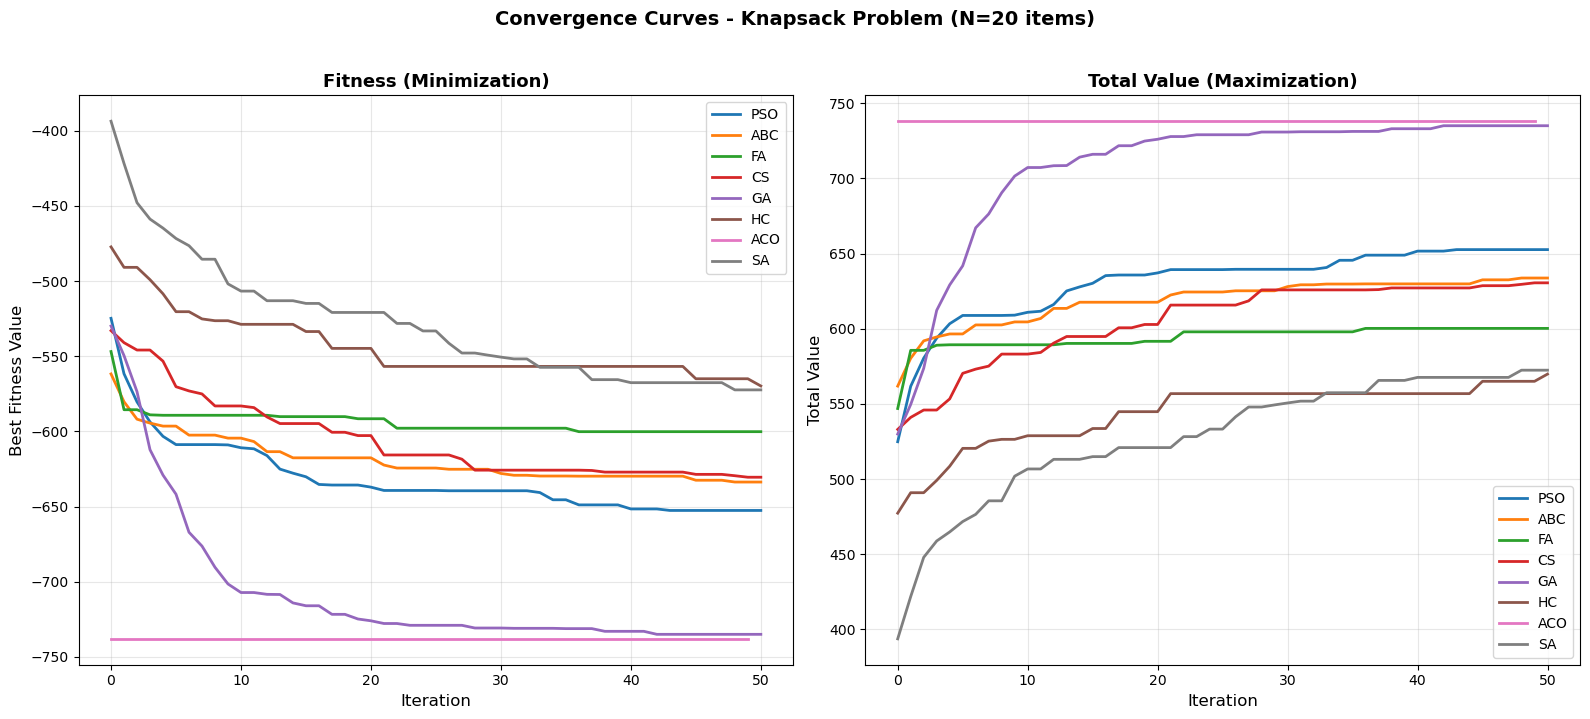

✓ Saved: ../results/convergence/convergence_knapsack_N50.png


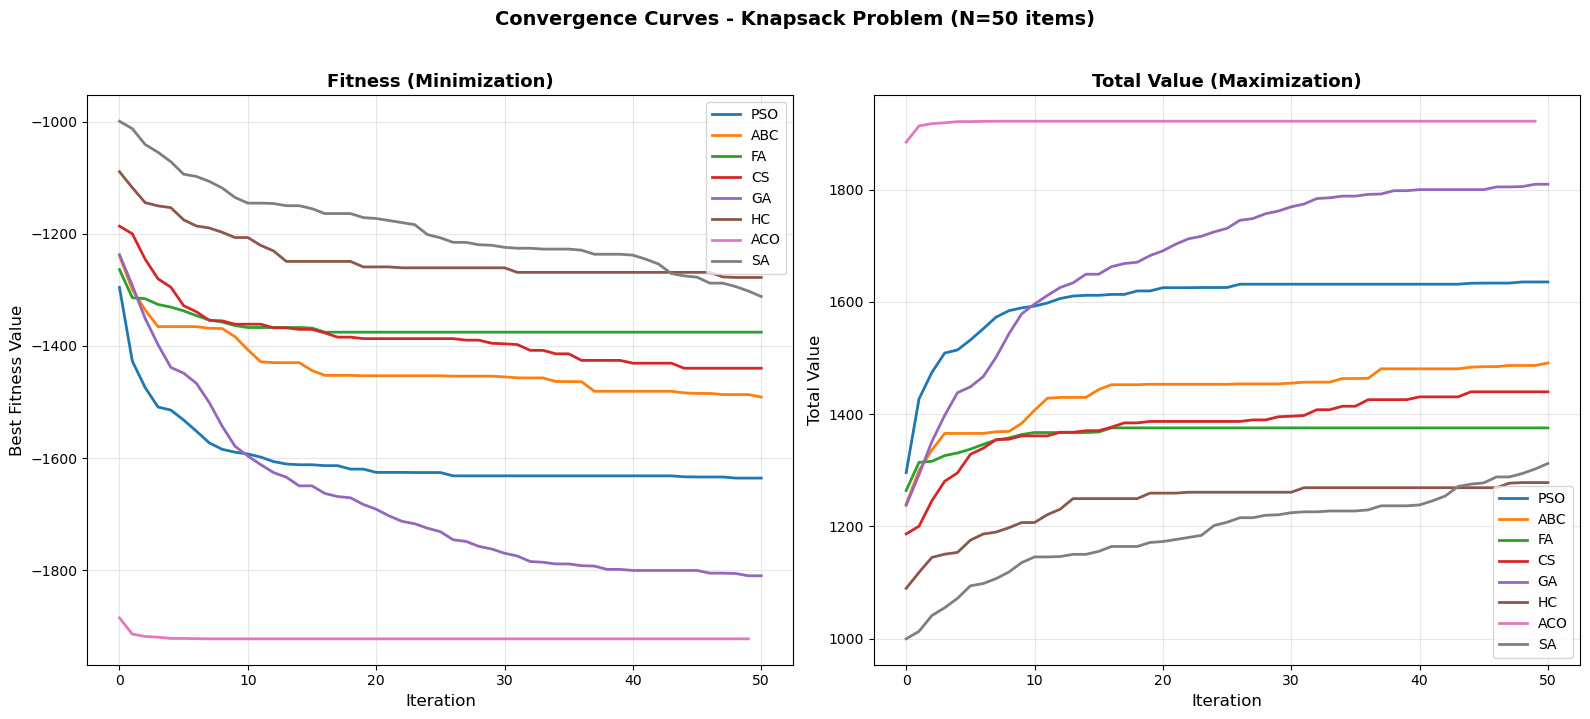

In [5]:
# Color scheme
colors = {
    'PSO': '#1f77b4',
    'ABC': '#ff7f0e',
    'FA': '#2ca02c',
    'CS': '#d62728',
    'GA': '#9467bd',
    'HC': '#8c564b',
    'ACO': '#e377c2',
    'SA': '#7f7f7f'
}

algorithms = ['PSO', 'ABC', 'FA', 'CS', 'GA', 'HC', 'ACO', 'SA']

# Create plots for each problem size
for n in N_ITEMS_LIST:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    for algo in algorithms:
        key = f"{algo}_N{n}"
        if algo in convergence_data[n]:
            # Left panel: Fitness (negative values, going down)
            ax1.plot(convergence_data[n][algo], label=algo,
                   linewidth=2, color=colors[algo])
            # Right panel: Total Value (positive values, going up)
            # Convert fitness to total_value by negating
            total_value_data = [-x for x in convergence_data[n][algo]]
            ax2.plot(total_value_data, label=algo,
                   linewidth=2, color=colors[algo])

    # Left panel settings
    ax1.set_xlabel('Iteration', fontsize=12)
    ax1.set_ylabel('Best Fitness Value', fontsize=12)
    ax1.set_title('Fitness (Minimization)', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Right panel settings
    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Total Value', fontsize=12)
    ax2.set_title('Total Value (Maximization)', fontsize=13, fontweight='bold')
    ax2.legend(loc='lower right', fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Overall title
    fig.suptitle(
        f'Convergence Curves - Knapsack Problem (N={n} items)', fontsize=14, fontweight='bold', y=1.02)

    # Save figure
    results_output_dir = os.path.join('..', 'results', 'convergence')
    os.makedirs(results_output_dir, exist_ok=True)
    output_file = os.path.join(results_output_dir, f'convergence_knapsack_N{n}.png')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_file}")
    
    # Display in notebook
    plt.show()


# Visualization: Robustness (Box Plots)

Create box plots to analyze algorithm robustness and stability across multiple runs.

- Shows distribution of fitness values from all runs
- Displays median (red line) and mean (blue dashed line)
- Helps identify algorithms with consistent performance vs. high variance
- Saves plots to `results/robustness/` directory


✓ Saved: ../results/robustness/robustness_knapsack_N20.png


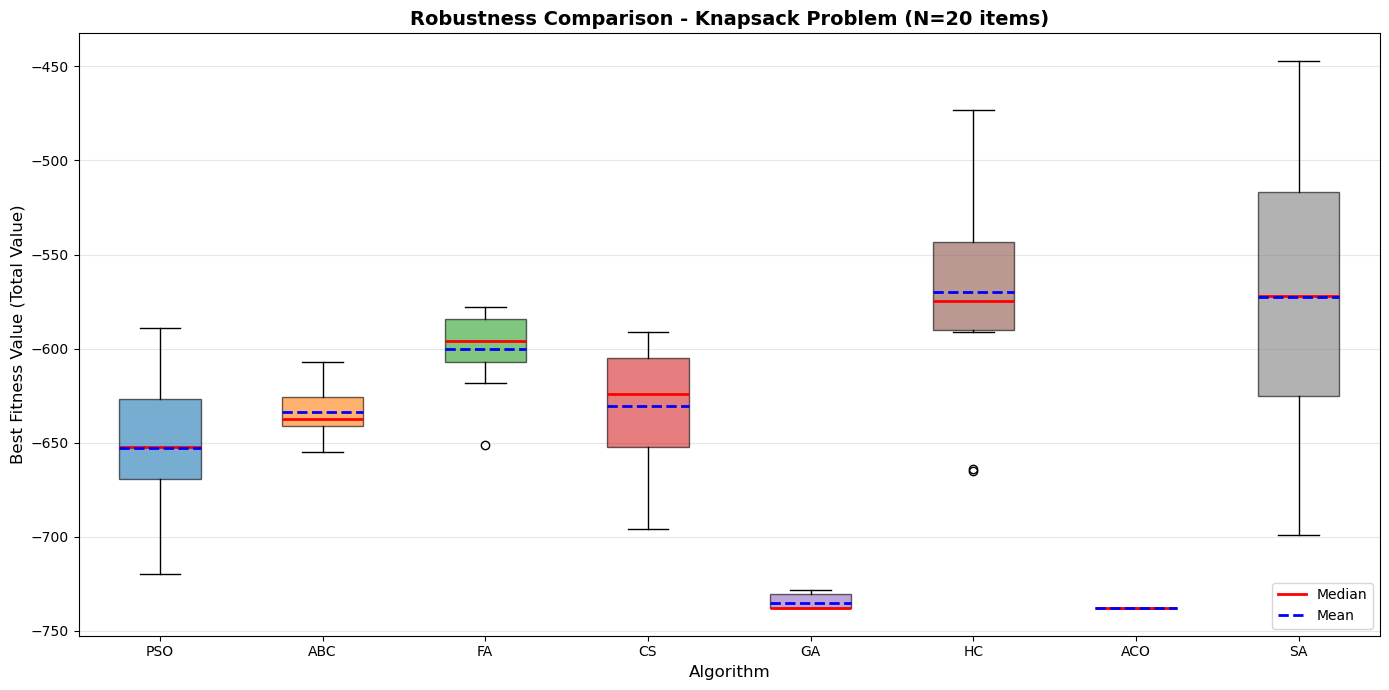

✓ Saved: ../results/robustness/robustness_knapsack_N50.png


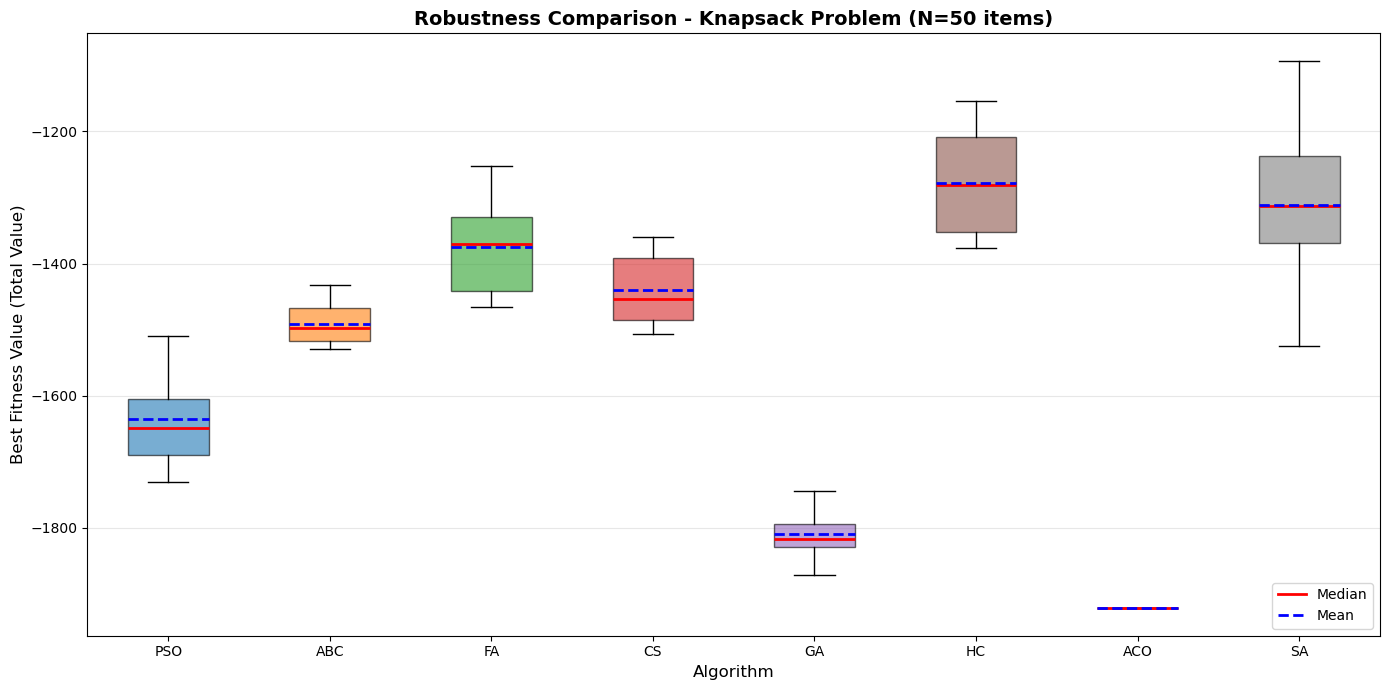

In [6]:
# Color scheme
colors = {
    'PSO': '#1f77b4',
    'ABC': '#ff7f0e',
    'FA': '#2ca02c',
    'CS': '#d62728',
    'GA': '#9467bd',
    'HC': '#8c564b',
    'ACO': '#e377c2',
    'SA': '#7f7f7f'
}

algorithms = ['PSO', 'ABC', 'FA', 'CS', 'GA', 'HC', 'ACO', 'SA']

# Create box plots for each problem size
for n in N_ITEMS_LIST:
    fig, ax = plt.subplots(figsize=(14, 7))

    # Prepare data for box plot
    plot_data = []
    labels = []
    box_colors = []

    for algo in algorithms:
        if algo in raw_fitness_data[n]:
            plot_data.append(raw_fitness_data[n][algo])
            labels.append(algo)
            box_colors.append(colors[algo])

    # Create box plot
    bp = ax.boxplot(plot_data, patch_artist=True,
                    showmeans=True, meanline=True,
                    medianprops=dict(color='red', linewidth=2),
                    meanprops=dict(color='blue', linewidth=2, linestyle='--'))
    # Set tick labels
    ax.set_xticklabels(labels)

    # Color the boxes
    for patch, color in zip(bp['boxes'], box_colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.6)

    ax.set_xlabel('Algorithm', fontsize=12)
    ax.set_ylabel('Best Fitness Value (Total Value)', fontsize=12)
    ax.set_title(f'Robustness Comparison - Knapsack Problem (N={n} items)',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='red', linewidth=2, label='Median'),
        Line2D([0], [0], color='blue', linewidth=2,
               linestyle='--', label='Mean')
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

    # Save figure
    results_output_dir = os.path.join('..', 'results', 'robustness')
    os.makedirs(results_output_dir, exist_ok=True)
    output_file = os.path.join(results_output_dir, f'robustness_knapsack_N{n}.png')
    plt.tight_layout()
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_file}")
    
    # Display in notebook
    plt.show()


# Visualization: Complexity Analysis

Analyze computational complexity by comparing execution time and memory usage across algorithms.

- Time complexity: Bar chart showing average execution time per algorithm
- Memory complexity: Bar chart showing average peak memory usage per algorithm
- Helps identify trade-offs between solution quality and computational cost
- Saves plots to `results/complexity/` directory


✓ Saved: ../results/complexity/complexity_knapsack_N20.png


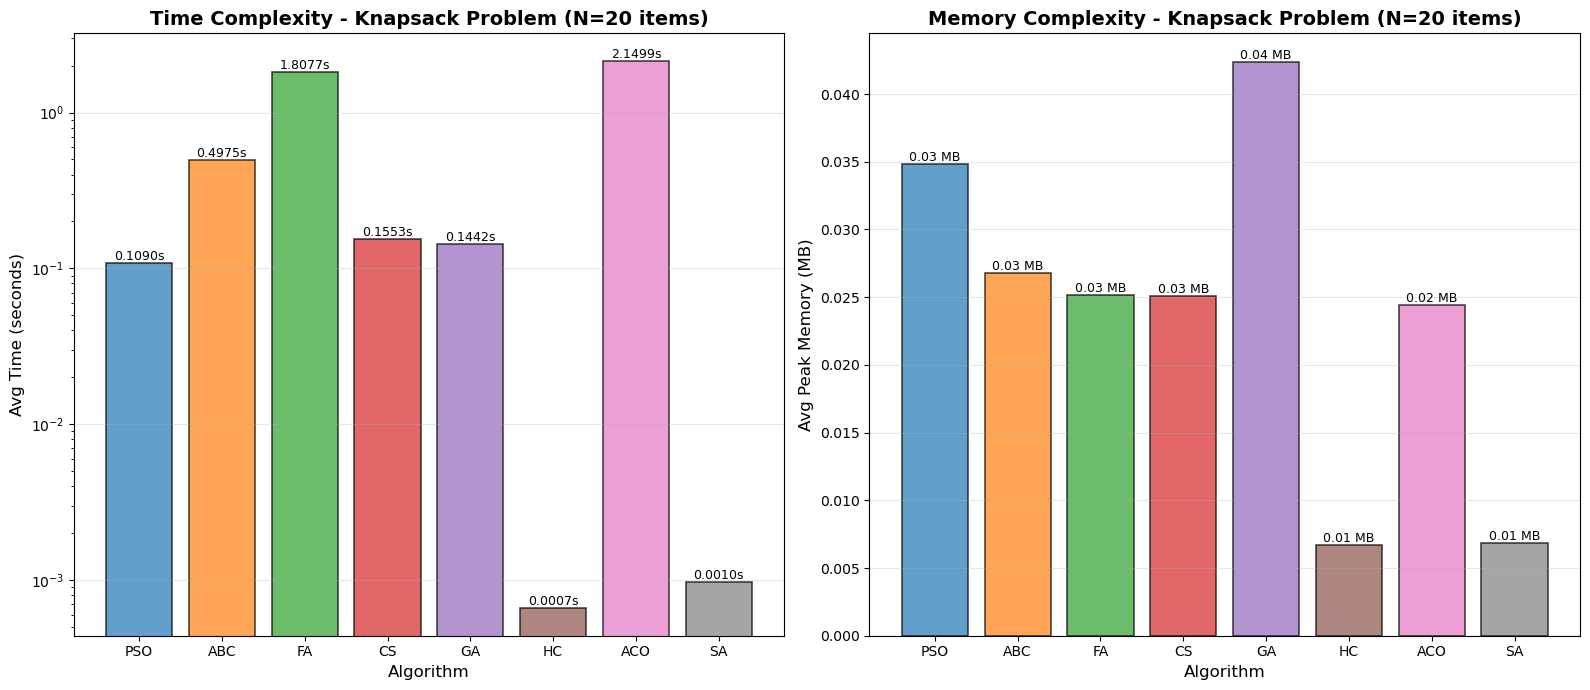

✓ Saved: ../results/complexity/complexity_knapsack_N50.png


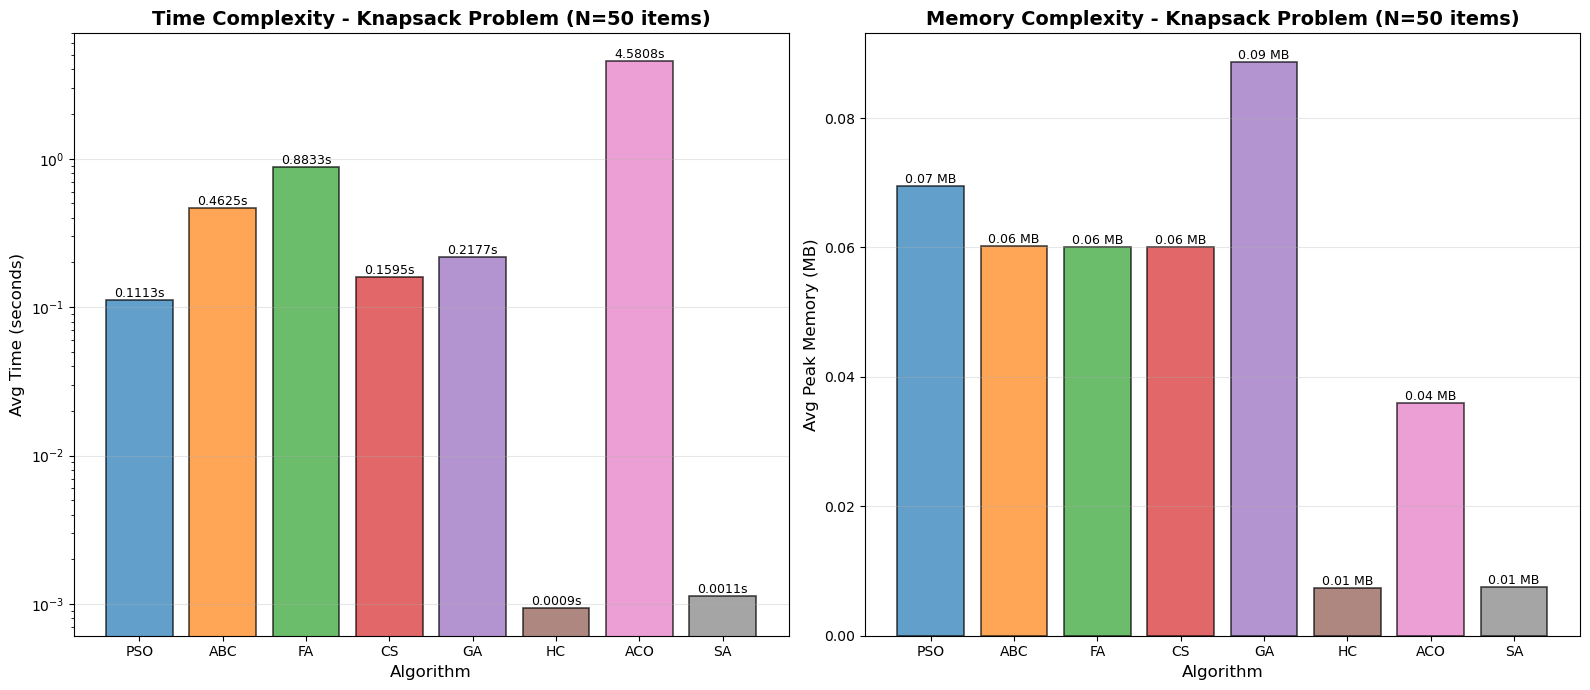

In [7]:
# Color scheme
colors = {
    'PSO': '#1f77b4',
    'ABC': '#ff7f0e',
    'FA': '#2ca02c',
    'CS': '#d62728',
    'GA': '#9467bd',
    'HC': '#8c564b',
    'ACO': '#e377c2',
    'SA': '#7f7f7f'
}

algorithms = ['PSO', 'ABC', 'FA', 'CS', 'GA', 'HC', 'ACO', 'SA']

# Create plots for each problem size
for n in N_ITEMS_LIST:
    # Prepare data for bar charts
    algo_names = []
    times = []
    memories = []
    bar_colors = []

    # Extract data from results_summary
    for entry in results_summary:
        if entry[1] == n:  # entry[1] is N_Items
            algo = entry[0]  # entry[0] is Algorithm
            if algo in algorithms:
                algo_names.append(algo)
                times.append(entry[6])  # entry[6] is Avg_Time
                memories.append(entry[7])  # entry[7] is Avg_Peak_Mem_MB
                bar_colors.append(colors[algo])

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

    # --- Time Complexity Bar Chart ---
    bars1 = ax1.bar(algo_names, times, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.2)
    ax1.set_xlabel('Algorithm', fontsize=12)
    ax1.set_ylabel('Avg Time (seconds)', fontsize=12)
    ax1.set_title(f'Time Complexity - Knapsack Problem (N={n} items)',
                  fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_yscale('log')  # Log scale for better visualization

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.4f}s',
                ha='center', va='bottom', fontsize=9)

    # --- Memory Complexity Bar Chart ---
    bars2 = ax2.bar(algo_names, memories, color=bar_colors, alpha=0.7, edgecolor='black', linewidth=1.2)
    ax2.set_xlabel('Algorithm', fontsize=12)
    ax2.set_ylabel('Avg Peak Memory (MB)', fontsize=12)
    ax2.set_title(f'Memory Complexity - Knapsack Problem (N={n} items)',
                  fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f} MB',
                ha='center', va='bottom', fontsize=9)

    plt.tight_layout()

    # Save figure
    results_output_dir = os.path.join('..', 'results', 'complexity')
    os.makedirs(results_output_dir, exist_ok=True)
    output_file = os.path.join(results_output_dir, f'complexity_knapsack_N{n}.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_file}")
    
    # Display in notebook
    plt.show()


# Visualization: Time vs Fitness Trade-off

Analyze the trade-off between computational time and solution quality using scatter plots.

- Each algorithm is represented as a point in the time-fitness space
- X-axis: Average execution time (log scale)
- Y-axis: Average fitness value
- Helps identify algorithms that balance speed and quality
- Saves plots to `results/tradeoff/` directory


✓ Saved: ../results/tradeoff/tradeoff_knapsack_N20.png


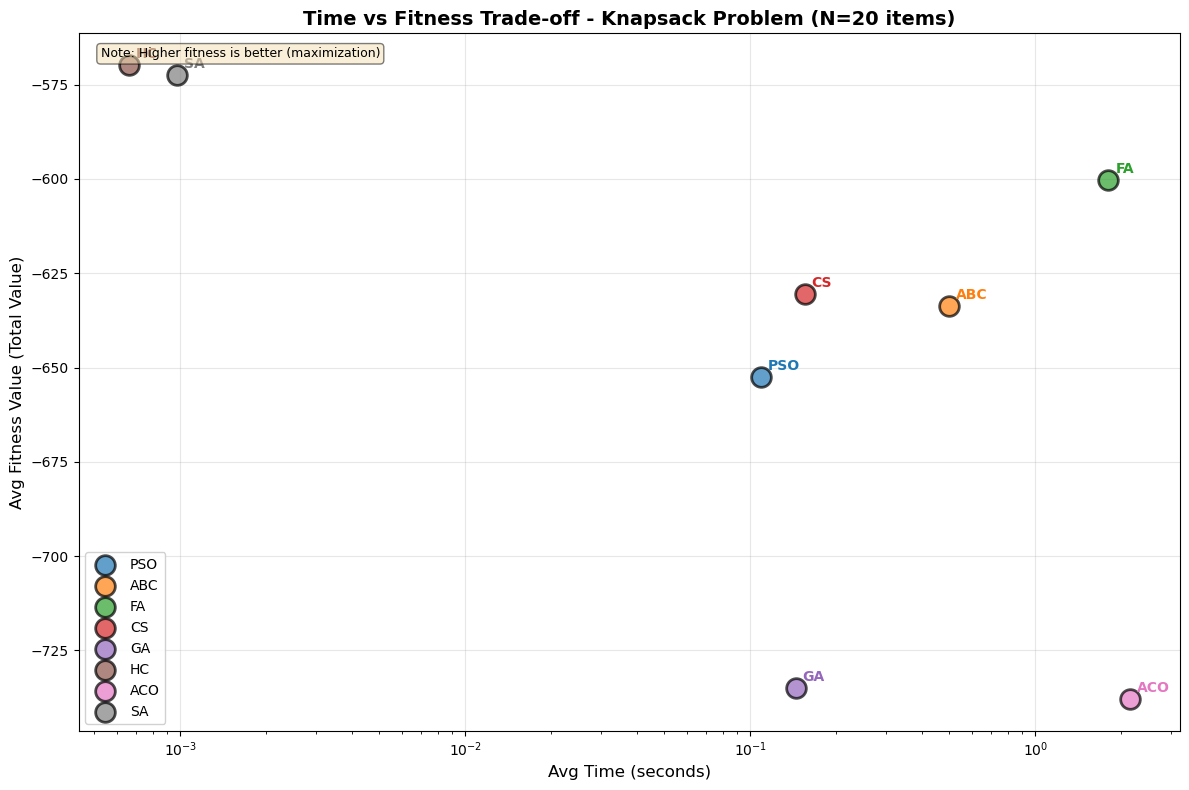

✓ Saved: ../results/tradeoff/tradeoff_knapsack_N50.png


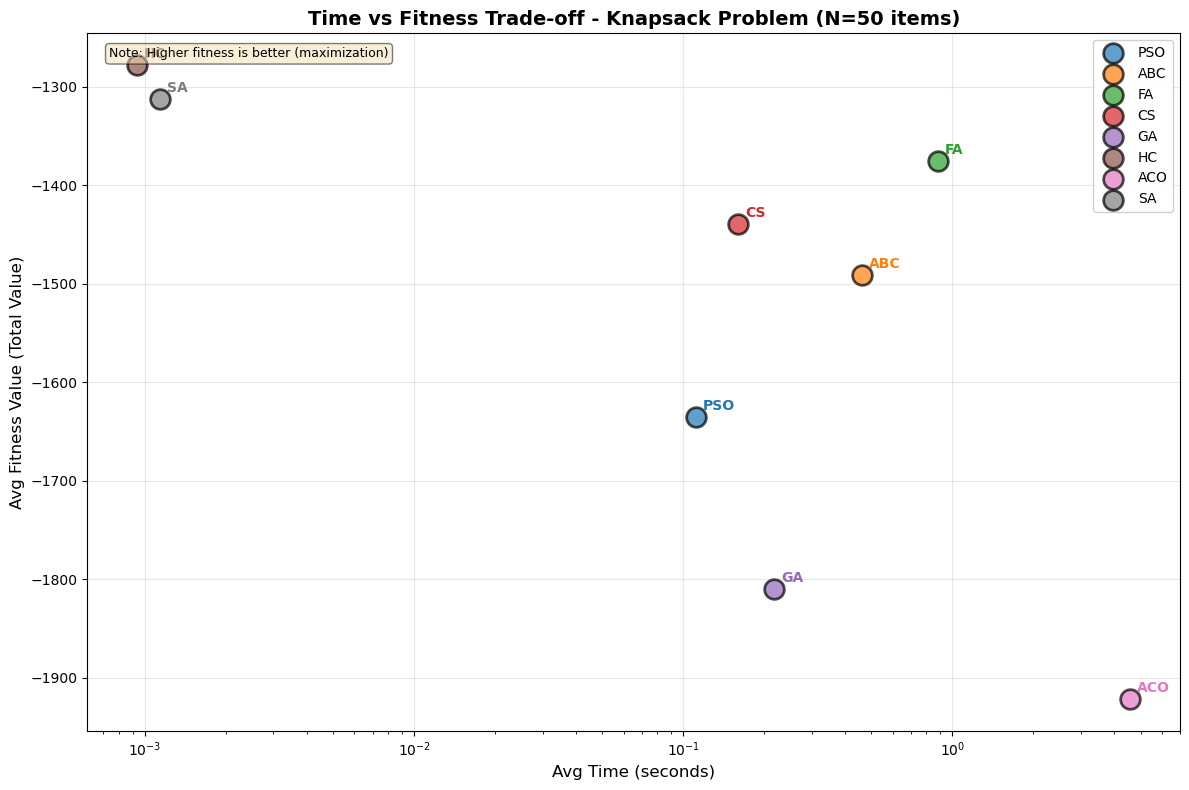

In [8]:
# Color scheme
colors = {
    'PSO': '#1f77b4',
    'ABC': '#ff7f0e',
    'FA': '#2ca02c',
    'CS': '#d62728',
    'GA': '#9467bd',
    'HC': '#8c564b',
    'ACO': '#e377c2',
    'SA': '#7f7f7f'
}

algorithms = ['PSO', 'ABC', 'FA', 'CS', 'GA', 'HC', 'ACO', 'SA']

# Prepare data from results_summary
data = {}
for entry in results_summary:
    algo = entry[0]      # Algorithm
    n_items = entry[1]   # N_Items
    avg_fitness = entry[2]  # Avg_Fitness
    avg_time = entry[6]    # Avg_Time
    
    key = f"{algo}_N{n_items}"
    if key not in data:
        data[key] = {'algo': algo, 'n_items': n_items, 'fitness': avg_fitness, 'time': avg_time}

# Create plots for each problem size
for n in N_ITEMS_LIST:
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot each algorithm as a point
    for algo in algorithms:
        key = f"{algo}_N{n}"
        if key in data:
            x = data[key]['time']
            y = data[key]['fitness']
            ax.scatter(x, y, s=200, color=colors[algo], alpha=0.7,
                      edgecolors='black', linewidth=2, label=algo, zorder=3)
            # Add algorithm label near the point
            ax.annotate(algo, (x, y), xytext=(5, 5), textcoords='offset points',
                       fontsize=10, fontweight='bold', color=colors[algo])

    ax.set_xlabel('Avg Time (seconds)', fontsize=12)
    ax.set_ylabel('Avg Fitness Value (Total Value)', fontsize=12)
    ax.set_title(f'Time vs Fitness Trade-off - Knapsack Problem (N={n} items)',
                 fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xscale('log')  # Log scale for time (better visualization)

    # Add legend
    ax.legend(loc='best', fontsize=10, framealpha=0.9)

    # Add note about optimization direction
    ax.text(0.02, 0.98, 'Note: Higher fitness is better (maximization)',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

    # Save figure
    results_output_dir = os.path.join('..', 'results', 'tradeoff')
    os.makedirs(results_output_dir, exist_ok=True)
    output_file = os.path.join(results_output_dir, f'tradeoff_knapsack_N{n}.png')
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {output_file}")
    
    # Display in notebook
    plt.show()
